In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import numpy as np
from scipy import stats

# add the top level directory to allow it to be imported
import sys
sys.path.append(os.path.split(os.getcwd())[0])
from utilities import plotting_utilities
from utilities import helper_functions

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## get table of data to load

In [2]:
data_path = os.path.join(os.path.split(os.getcwd())[0],'data')
session_list = pd.read_csv(os.path.join(os.path.join(data_path,'session_list.csv')))
anesthesia_sessions = session_list.query('session_type == "anesthesia"')
anesthesia_sessions

,mouse_id,sex,genotype,AP_coord,ML_coord,DV_coord,session_type,recording_date,processing_date
0,M334412,M,Gnb4-IRES2-Cre;AAV-GCaMP6s,1.5,2.625,2.7,anesthesia,0,2019-03-14 17:37:57.629808903-07:00
1,M348126,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,1.5,2.625,2.5,anesthesia,0,2019-03-14 19:28:13.741096020-07:00
2,M339255,F,Gnb4-IRES2-Cre;AAV-GCaMP6s,1.5,2.625,2.7,anesthesia,0,2019-03-14 23:05:12.098660707-07:00
3,M334410,M,Gnb4-IRES2-Cre;AAV-GCaMP6s,1.5,2.625,2.5,anesthesia,0,2019-03-15 02:11:08.873144865-07:00
4,M335379,M,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,1.5,3.125,2.5,anesthesia,0,2019-03-15 05:08:14.018605709-07:00
5,M375765,M,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,2.625,2.5,anesthesia,0,2019-03-15 07:12:19.855928898-07:00
6,M397408,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,2.625,2.5,anesthesia,0,2019-03-13 20:32:17.976514578-07:00
7,M416531,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,3.125,2.5,anesthesia,0,2019-03-25 16:23:02.121844530-07:00


## load data for all sessions

In [3]:
session = {}
pre_anesthesia_frames_df = pd.read_csv(os.path.join(data_path,'anesthesia_sessions','pre_anesthesia_frames.csv'))
for idx,row in anesthesia_sessions.iterrows():
    print('on session {} of {}'.format(idx+1,len(anesthesia_sessions)), end = '\r')
    mouse_id = row['mouse_id']
    session[mouse_id] = helper_functions.load_session(row['mouse_id'], session_type='anesthesia')
    
    pre_anesthesia_frames = pre_anesthesia_frames_df.query('mouse_id == @mouse_id')['pre_anesthesia_frames'].values[0]
    time = session[mouse_id].filtered_traces['t']
    session[mouse_id].filtered_traces['t_relative'] = time - time[pre_anesthesia_frames]


In [4]:
all_dfs = []
for mouse_id in session.keys():
    
    all_dfs.append(session[mouse_id].filtered_traces.rename(columns={C:'{}_{}'.format(C,mouse_id,) for C in session[mouse_id].filtered_traces if C.startswith('C')}))
    # note: by scaling, rounding, then casting to int, I'm ensuring that the 't_relative_scaled' column can be used
    #       as the merge-on column below without issues due to decimal resolution
    all_dfs[-1]['t_relative_scaled'] = all_dfs[-1]['t_relative'].map(lambda x:int(round(x*100)))

In [5]:
traces_merged = all_dfs[0].copy().drop(columns=['t', 't_relative'])
for i in range(1,len(all_dfs)):
    traces_merged = traces_merged.merge(
        all_dfs[i].drop(columns=['t', 't_relative']),
        on='t_relative_scaled',
        how='outer'
    ).sort_values(by='t_relative_scaled')

# rescale time (multiplied by 100 above to avoid decimal precision issues)
traces_merged['t_relative'] = traces_merged['t_relative_scaled'].map(lambda x:x/100)

## a function for plotting the combined heatmap

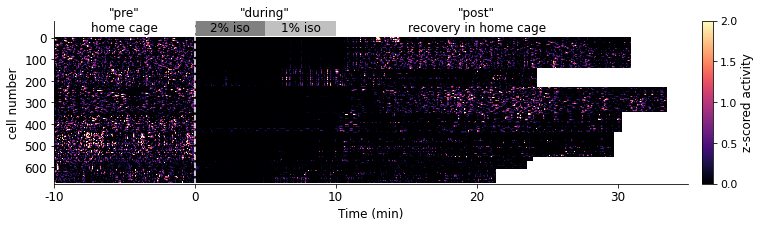

In [37]:
def plot_combined_heatmap(ax=None):
    if ax is None:
        fig,ax=plt.subplots(figsize=(12,3))
    helper_functions.heat_plot(
        traces_merged, 
        ax=ax, 
        clim=[0,2], 
        time_label='t_relative',
        cbar_ticklabel_fontsize=11
    )
    ax.axvline(0,color='white',linestyle='dashed')
    ax.set_xticks([-600,0,600,1200,1800]);
    ax.set_xticklabels([-10,0,10,20,30], fontsize=12)
    for label in ax.get_yticklabels():
        label.set_fontsize(12)
    ax.set_xlim(-10*60, 35*60)
    ax.set_xlabel('Time (min)', fontsize=12);
    ax.set_ylabel('cell number', fontsize=12);
    sns.despine()
    
    box_height = 80
    ax.set_ylim(len(traces_merged.columns), -box_height)
    
    rects = []
    rects.append(patches.Rectangle((0, -box_height), 300, box_height - 10, linewidth=1, edgecolor=None, facecolor='gray'))
    rects.append(patches.Rectangle((300, -box_height), 300, box_height - 10, linewidth=1, edgecolor=None, facecolor='silver'))
    [ax.add_patch(rect) for rect in rects]
    
    ax.text(-300, -15, 'home cage', ha='center', va='bottom', fontsize=12)
    ax.text(150, -15, '2% iso', ha='center', va='bottom', fontsize=12)
    ax.text(450, -15, '1% iso', ha='center', va='bottom', fontsize=12)
    ax.text(1200, -15, 'recovery in home cage', ha='center', va='bottom', fontsize=12)
    
    ax.text(-300, -85, '"pre"', ha='center', va='bottom', fontsize=12)
    ax.text(300, -85, '"during"', ha='center', va='bottom', fontsize=12)
    ax.text(1200, -85, '"post"', ha='center', va='bottom', fontsize=12)
    
    
plot_combined_heatmap()

## a function for building a dataframe containing the activity for each cell, allowing comparison across epochs

In [14]:
def build_variance_df(traces_merged):
    cell_ids = [c for c in traces_merged.columns if c.startswith('C')]

    # build a dataframe of pre-anesthesia values
    df_pre = pd.DataFrame(traces_merged.query('t_relative<0')[cell_ids].var(axis=0))
    df_pre = df_pre.rename(columns={0:'variance'})
    df_pre['condition'] = 'pre_variance'

    # build a dataframe of anesthesia values - first 10 minutes of post-anesthesia recording
    df_iso = pd.DataFrame(traces_merged.query('t_relative>0 and t_relative < 600')[cell_ids].var(axis=0))
    df_iso  = df_iso.rename(columns={0:'variance'})
    df_iso['condition'] = 'iso_variance'

    # build a dataframe of post-anesthesia values - last 10 minutes of post-anesthesia recording
    df_post = []
    for cell in cell_ids:
        final_time = traces_merged['t_relative'][pd.notnull(traces_merged[cell])].max()
        v = traces_merged[[cell,'t_relative']].query('t_relative>(@final_time-600) and t_relative<@final_time')
        df_post.append({
            'cell_id':cell,
            'variance':v[cell].var(),
            'condition':'post_variance'
        })
    df_post = pd.DataFrame(df_post).set_index('cell_id')

    df_all = pd.concat([df_pre,df_iso,df_post])
    
    df_all['mouse_id'] = None
    df_all['cell_id'] = None

    for idx, row in df_all.iterrows():
        df_all.at[idx, 'cell_id'], df_all.at[idx, 'mouse_id'] = idx.split('_')
        
    return df_all

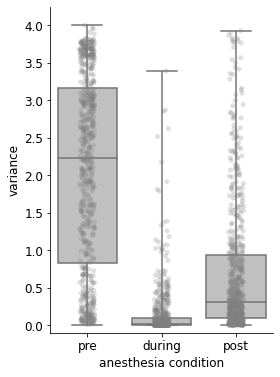

In [15]:
def plot_variance(ax=None, ymax=4.25):
    
    if ax is None:
        fig,ax=plt.subplots(figsize=(4,6))
        
    variance_df = build_variance_df(traces_merged)
    sns.stripplot(
        x='condition',
        y='variance',
        data=variance_df,
        ax=ax,
        alpha=0.25,
        palette = ['gray','gray','gray']
    )
    sns.boxplot(
        x='condition',
        y='variance',
        data=variance_df,
        ax=ax,
        whis=np.inf,
        palette = ['silver','silver','silver']
    )
    
    ax.set_xticklabels([
        'pre',
        'during',
        'post'
    ])
    
    ax.set_ylim(-0.1, ymax)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)
    ax.set_xlabel('anesthesia condition', fontsize=12)
    ax.set_ylabel('variance', fontsize=12)

    sns.despine()
    
plot_variance()

/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


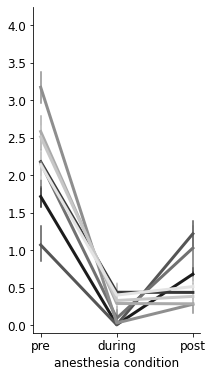

In [16]:
def plot_variance_by_mouse(ax=None, ymax=4.25):
    
    if ax is None:
        fig,ax=plt.subplots(figsize=(3,6))
        
    variance_df = build_variance_df(traces_merged)
        
    sns.lineplot(
        data=variance_df,
        x="condition", 
        y="variance", 
        hue="mouse_id", 
        err_style="bars", 
        ci=95,
        ax=ax,
        linewidth = 3,
        legend=False,
        palette='gray'
    )
    
    sns.despine()
    
    ax.set_xticklabels([
        'pre',
        'during',
        'post'
    ])
    
    ax.set_ylim(-0.1, ymax)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)
    ax.set_xlabel('anesthesia condition', fontsize=12)
    ax.set_ylabel('')

plot_variance_by_mouse(ax=None)

/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


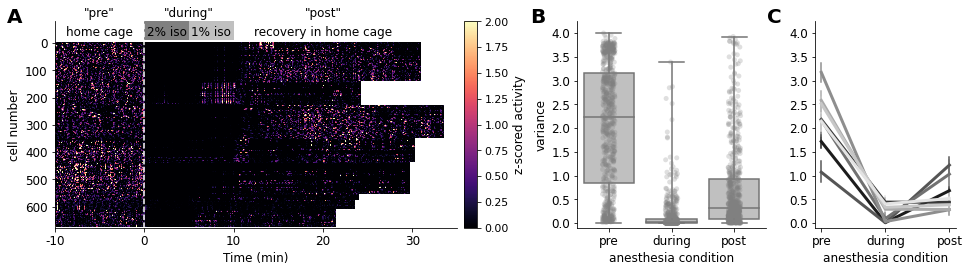

In [38]:
save_fig = True

figsize=(2*8.5,2*2)
figure = plt.figure(figsize=figsize)
axes = {
    'A':plotting_utilities.placeAxesOnGrid(figure, xspan=[0.05,0.5], yspan=[0.05,1]),
    'B':plotting_utilities.placeAxesOnGrid(figure, xspan=[0.6,0.8], yspan=[0.05,1]),
    'C':plotting_utilities.placeAxesOnGrid(figure, xspan=[0.85,1], yspan=[0.05,1]),
}
    
plot_combined_heatmap(axes['A'])
plot_variance(axes['B'])
plot_variance_by_mouse(axes['C'])

# add labels
labels = [
    {'label_text':'A', 'xpos':0,   'ypos':0.05},
    {'label_text':'B', 'xpos':0.55, 'ypos':0.05},
    {'label_text':'C', 'xpos':0.8, 'ypos':0.05},
]
for label in labels:
    plotting_utilities.add_label(
        figure,
        label_text = label['label_text'],
        xpos = label['xpos'],
        ypos = label['ypos'],
        fontsize=20,
        weight="bold"
    )
    
if save_fig:
    plotting_utilities.save_figure(figure, fname='figure_2', formats=['.png','.pdf'], size=figsize, dpi=500)

## stats on B

In [18]:
df_all = build_variance_df(traces_merged)

stats.ttest_ind(
    df_all.query("condition == 'pre_variance'")['variance'],
    df_all.query("condition == 'iso_variance'")['variance']
)

Ttest_indResult(statistic=38.02092001840428, pvalue=1.2169301695655555e-215)

In [19]:
stats.ttest_ind(
    df_all.query("condition == 'iso_variance'")['variance'],
    df_all.query("condition == 'post_variance'")['variance']
)

Ttest_indResult(statistic=-15.238500928432252, pvalue=1.6718231024468605e-48)

In [20]:
stats.ttest_ind(
    df_all.query("condition == 'pre_variance'")['variance'],
    df_all.query("condition == 'post_variance'")['variance']
)

Ttest_indResult(statistic=23.254944337522375, pvalue=7.053292400199188e-101)

In [21]:
df_all.query("condition == 'pre_variance'")['variance'].describe()

count    676.000000
mean       2.069723
std        1.274670
min        0.009126
25%        0.835425
50%        2.235371
75%        3.167180
max        4.001505
Name: variance, dtype: float64

In [22]:
df_all.query("condition == 'iso_variance'")['variance'].describe()

count    676.000000
mean       0.136637
std        0.350229
min        0.000056
25%        0.002719
50%        0.012320
75%        0.093218
max        3.390435
Name: variance, dtype: float64

In [23]:
df_all.query("condition == 'post_variance'")['variance'].describe()

count    676.000000
mean       0.687905
std        0.872939
min        0.000199
25%        0.093323
50%        0.316199
75%        0.933173
max        3.927539
Name: variance, dtype: float64

In [24]:
len(traces_merged.columns)

678